## **MULTILABEL CLASSIFICATION EXAMPLE**

- Some explanations to understand the difference between multiclass and multilabel:

**multiclass** = dog, cat, bird (3 columns)

**multilabel** = 1, 1, 0 (more than 1 exlusive class)

**n_label** = 2  --> means that the average of exclusive class per observation are 2

### Packages

In [1]:
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import seaborn as sns
import numpy as np
from collections import Counter

/home/codespace/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data Preparation and Train Test Split

In [2]:
X, y = make_multilabel_classification(n_samples=10000, n_features=10, n_classes=3, n_labels=2)
X_torch = torch.FloatTensor(X) #tensor for independient features
y_torch = torch.FloatTensor(y) #tensor for dependient feature

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_torch, y_torch, test_size = 0.2)

### Dataset and Dataloader

In [13]:
class MultilabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

multilabel_train_data = MultilabelDataset(X_train, y_train)
multilabel_test_data = MultilabelDataset(X_test, y_test)

train_loader = DataLoader(dataset = multilabel_train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset = multilabel_test_data, batch_size=10, shuffle=True)

### Define the Model Network

In [21]:
class MultilabelNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultilabelNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) #fully connected layer
        self.relu = nn.ReLU() #rectified linear unit
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_dim = multilabel_train_data.X.shape[1] #10 independent columns
output_dim = multilabel_train_data.y.shape[1] #3 target columns

model = MultilabelNetwork(input_size=input_dim, hidden_size=20, output_size=output_dim)
model.train()

MultilabelNetwork(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

In [22]:
print(multilabel_train_data.X.shape[1])
print(multilabel_train_data.y.shape[1])

10
3


In [31]:
loss_fn = nn.BCEWithLogitsLoss() #Binary Cross, because the results are 0 or 1
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
losses = []
slope, bias = [], []
number_epochs = 100
for epoch in range(number_epochs):
    for j, (X, y) in enumerate(train_loader): #y = target variables
        
        # optimization
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X)

        # compute loss
        y_pred_class = y_pred.round()
        loss = loss_fn(y_pred_class, y)

        # backprop
        loss.backward()

        # update weights
        optimizer.step()
    
    if (epoch % 10 == 0):
        current_loss = loss.item()
        print(f"Epoch {epoch}, Loss: {current_loss}")
        losses.append(current_loss) #item() is used to extract this value as a floating number

Epoch 0, Loss: 0.41456449031829834
Epoch 10, Loss: 0.5998520255088806
Epoch 20, Loss: 0.6445453763008118
Epoch 30, Loss: 0.5985491871833801
Epoch 40, Loss: 0.5698710680007935
Epoch 50, Loss: 0.536537766456604
Epoch 60, Loss: 0.45255306363105774
Epoch 70, Loss: 0.6065568327903748
Epoch 80, Loss: 0.49054160714149475
Epoch 90, Loss: 0.5618634819984436


In [32]:
len(losses)

10

<Axes: >

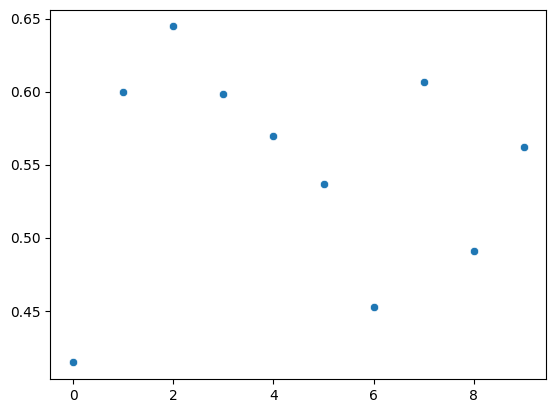

In [34]:
sns.scatterplot(x=range(len(losses)), y=losses)

### Test the Model

In [37]:
with torch.no_grad():
    y_test_pred = model(X_test).round()

In [38]:
y_test_pred

tensor([[0., 1., 1.],
        [0., 0., 1.],
        [0., 1., 1.],
        ...,
        [0., 1., 1.],
        [1., 1., 1.],
        [0., 1., 1.]])

### Naive Classifier Accuracy

In [41]:
y_test_str = [str(i) for i in y_test.detach().numpy()]

most_common_cnt = Counter(y_test_str).most_common()[0][1]
print(f"Naive classifier: {most_common_cnt/len(y_test_str) * 100}%")

Naive classifier: 29.5%


In [45]:
most_common_cnt

[('[0. 1. 1.]', 590),
 ('[1. 1. 1.]', 419),
 ('[0. 0. 1.]', 395),
 ('[0. 0. 0.]', 308),
 ('[0. 1. 0.]', 233),
 ('[1. 0. 1.]', 28),
 ('[1. 0. 0.]', 16),
 ('[1. 1. 0.]', 11)]

In [46]:
Counter(y_test_str).most_common()[0][1]

590

In [47]:
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_acc * 100}%")

Test accuracy: 76.1%


---------